In [1]:
#EDA
import os
import pandas as pd
import fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import numpy as np
import gc

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
#Model
import lightgbm as lgb

/opt/conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Giảm kích cỡ dữ liệu
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# I. EDA
## 1. Đọc dataset

In [3]:
data_path = '/kaggle/input/predict-future-sales'
sales_train      = pd.read_csv(os.path.join(data_path, 'sales_train.csv'))
shops            = pd.read_csv(os.path.join(data_path, 'shops.csv'))
items            = pd.read_csv(os.path.join(data_path, 'items.csv'))
item_categories  = pd.read_csv(os.path.join(data_path, 'item_categories.csv'))
test             = pd.read_csv(os.path.join(data_path, 'test.csv'))

## 2. Khám phá các dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


## 3. Khám phá sales_train

Số giá trị NULL và NA ở tập sales_train:

In [8]:
print(sales_train.isnull().sum())
print(sales_train.isna().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


Boxplot của hai cột item_cnt_day và item_price

<function matplotlib.pyplot.show(close=None, block=None)>

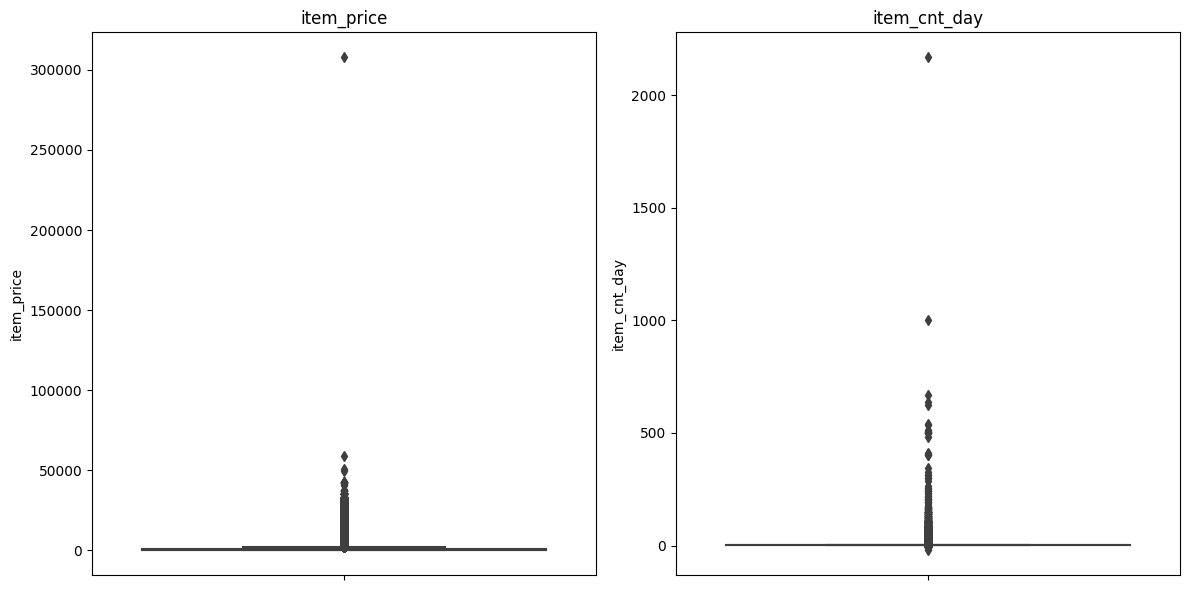

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y=sales_train['item_price'], ax=axes[0])
axes[0].set_title('item_price')
sns.boxplot(y=sales_train['item_cnt_day'], ax=axes[1])
axes[1].set_title('item_cnt_day')

plt.tight_layout()  
plt.show

Theo quan sát thì ta có thể đoán được rằng những giá trị item_price > 50000 và item_cnt_day > 1000 sẽ là outlier. Ngoài ra ở trên ta thấy cột item_cnt_day xuất hiện giá trị âm, đây có thể là những đơn hàng hoàn trả hoặc nhập liệu lỗi nên ta sẽ không tính những đơn này.

In [10]:
sales_train = sales_train[(sales_train['item_price'] > 0) & (sales_train['item_price'] < 50000)]
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < 1000)]

In [11]:
sales_train_grouped = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])\
                                          .agg({'item_cnt_day': 'sum'}).reset_index()

Tổng số sản phẩm được bán theo từng tháng:

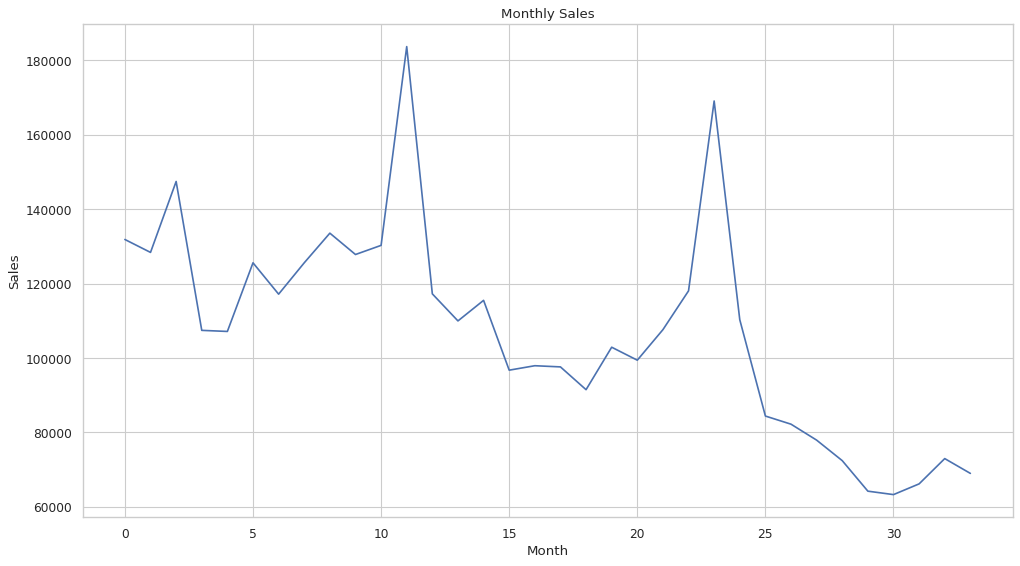

In [12]:
tmp = sales_train_grouped.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
sns.set(style="whitegrid")

plt.figure(figsize=(15, 8), dpi=80)
sns.lineplot(data=tmp, x='date_block_num', y='item_cnt_day')

plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')

plt.show()

Số lượng sản phẩm bán ra đang có xu hướng giảm dần. Ở mỗi năm thì tháng 12 có tổng doanh số cao nhất

Biểu đồ mật độ xác suất giá trị số lượng sản phẩm bán ra mỗi tháng 

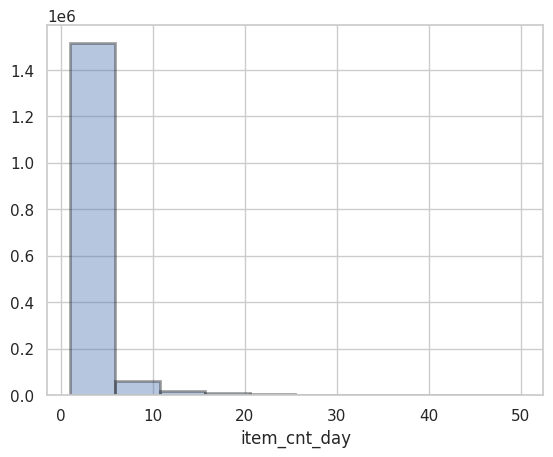

In [13]:
tmp = sales_train_grouped[sales_train_grouped['item_cnt_day'].between(0, 50)]
sns.distplot(tmp['item_cnt_day'], bins=10, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.show()

Ta nhận thấy rằng số lượng bán ra của một sản phẩm trong một shop trong một tháng hầu hết đều nằm trong khoảng 1-10. Ta có thể clip giá trị về khoảng 0-20 để hạn chế các giá trị outlier.

## 4. Khám phá `shops`, `items`, `item_categories` và Labels encoding

Các tập dữ liệu `shops` và `item_categories` được dịch sang tiếng Anh để quá trình xử lí dữ liệu dễ hiểu và trực quan hơn. Việc dịch vẫn đảm bảo giữ lại ý nghĩa và thông tin ban đầu mà cả hai tập dữ liệu (bằng tiếng Nga) cung cấp.

In [14]:
shops            = pd.read_csv(os.path.join(data_path, 'shops_eng.csv'))
item_categories  = pd.read_csv(os.path.join(data_path, 'item_categories_eng.csv'))

### 4.1 `shops`

In [15]:
shops.head()

,shop_name,shop_id
0,Yakutsk Ordzhonikidze 56 fran,0
1,Yakutsk TC Central fran,1
2,Adygea TC Mega,2
3,Balashikha TRC October-Kinomir,3
4,Volzhsky TC Volga Mall,4


Chuyển tất cả kí tự về lowercase

In [16]:
shops['shop_name'] = shops['shop_name'].str.lower()

Sử dụng fuzzywuzzy để tìm những shop tương đồng

In [17]:
def find_similar_shop_names(names, shop_ids):
    similar_names_groups = []
    for i, name in enumerate(names):
        shop_info = {"shop_name": name, "shop_id": shop_ids[i]}
        current_group = [shop_info]
        for j, other_name in enumerate(names):
            if i != j:
                ratio = fuzzywuzzy.fuzz.ratio(name, other_name)
                threshold = 80
                if ratio >= threshold:
                    shop_info = {"shop_name": other_name, "shop_id": shop_ids[j]}
                    current_group.append(shop_info)
        if len(current_group) > 1:
            similar_names_groups.append(current_group)
    similar_names_list = [list(group) for group in similar_names_groups]
    return similar_names_list

similar_names = find_similar_shop_names(shops['shop_name'].tolist(), shops['shop_id'].tolist())
group_ids = set()
for group in similar_names:
    #print('shop_id_01:', group[0]['shop_id'], 'shop_name_01:', group[0]['shop_name'], '--similar with--', 'shop_id_02:', group[1]['shop_id'], 'shop_name_02:', group[1]['shop_name'])
    shop_id_01 = int(group[0]['shop_id'])
    shop_id_02 = int(group[1]['shop_id'])
    if ((shop_id_01, shop_id_02) not in group_ids) and ((shop_id_02, shop_id_01) not in group_ids):
        group_ids.add((shop_id_01, shop_id_02))
        print('Shop with ID:', shop_id_01, 'and', shop_id_02, ':')
        print('  ', group[0]['shop_name'])
        print('  ', group[1]['shop_name'])

Shop with ID: 0 and 57 :
   yakutsk ordzhonikidze 56 fran
   yakutsk ordzhonikidze 56
Shop with ID: 1 and 58 :
   yakutsk tc central fran
   yakutsk tc central
Shop with ID: 10 and 11 :
   zhukovsky st chkalova 39m
   zhukovsky st chkalova 39m
Shop with ID: 23 and 24 :
   moscow tc budenovsky pava2
   moscow tc budenovsky pavk7
Shop with ID: 30 and 31 :
   moscow tc perlovsky
   moscow tc semenovsky
Shop with ID: 39 and 40 :
   rostov-on-don trk megacenter horizon
   rostov-on-don trk megacenter horizon ostrovnoy


**Nhận xét**:
- [x] Shop `0` và `57`: tương tự nhau, chỉ khác "fran", phần này là vô nghĩa nên ta xác định hai shop là một.
- [x] Shop `1` và `58`: trường hợp tương tự trên.
- [x] Shop `10` và `11`: hai shop là một.
- [ ] Shop `23` và `24`: hai shop được xác định bằng 2 mã gian hàng khác nhau "pava2" và "pavk7" nên đây là 2 shop riêng biệt.
- [ ] Shop `30` và `31`, `38` và `54`: hai shop riêng biệt, chỉ là tên gần giống.
- [x] Shop `39` và `40`: tương tự với trường hợp đầu tiên, đó không dùng để chỉ 2 shop khác nhau.<br>

Ta thực hiện đồng bộ các tên chỉ dùng để chỉ cùng 1 shop.

In [18]:
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

Trong cột dữ liệu `shop_name`, ta thấy cấu trúc tên shop lần lượt bao gồm các phần:
- Tên thành phố của shop đó.
- Phân loại của shop đó (trung tâm thương mại, cửa hàng bán lẻ, ...)


**Labels Encoding** cho tập dữ liệu `shops`

In [19]:
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops['shop_category'] = shops['shop_name'].str.split().str[1]
#Sử dụng LabelEncoder
label_encoder = LabelEncoder()
shops['shop_city'] = label_encoder.fit_transform(shops['shop_city'])
shops['shop_category'] = label_encoder.fit_transform(shops['shop_category'])

Bỏ shopname vì nó không mang lại giá trị.

In [20]:
shops = shops.drop('shop_name', axis=1)
shops.head(3)

,shop_id,shop_city,shop_category
0,0,28,3
1,1,28,10
2,2,0,10


Xác định được hai feature:
1. `shop_city`
2. `shop_category`

### 4.2 `item_categories`

In [21]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC Headsets/Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2


Cấu trúc tên phân loại sản phẩm bao gồm từ đầu tiên là để xác định nhóm của phân loại sản phẩm đó.

In [22]:
item_categories['item_category_group'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  
item_categories['item_category_group'].value_counts()

item_category_group
Games          14
Books          13
Gifts          12
Gaming          8
Accessories     7
Software        6
Payment         5
Movies          5
Music           5
Office          2
Blank           2
PC              1
Digital         1
Delivery        1
Batteries       1
Name: count, dtype: int64

Tuy nhiên, có thể thấy một vài nhóm phân loại sản phẩm có số lượng khá ít, vì vậy ta thực hiện các công việc xử lí:
- Gom các nhóm phân loại có ít hơn 5 loại vào nhóm `etc`

In [23]:
#Thực hiện thay thế bằng 'etc'
def make_etc(x):
    if len(item_categories[item_categories['item_category_group'] == x]) >= 5:
        return x
    else:
        return 'etc'

item_categories['item_category_group'] = item_categories['item_category_group'].apply(make_etc)
label_encoder = LabelEncoder()
item_categories['item_category_group_name']  = item_categories['item_category_group']
item_categories['item_category_group'].value_counts()

item_category_group
Games          14
Books          13
Gifts          12
etc             8
Gaming          8
Accessories     7
Software        6
Payment         5
Movies          5
Music           5
Name: count, dtype: int64

In [24]:
#Bỏ item_category_name
#item_categories = item_categories.drop('item_category_name', axis=1)
item_categories['item_category_group'] = label_encoder.fit_transform(item_categories['item_category_group'])
item_categories.head(3)

,item_category_name,item_category_id,item_category_group,item_category_group_name
0,PC Headsets/Headphones,0,9,etc
1,Accessories - PS2,1,0,Accessories
2,Accessories - PS3,2,0,Accessories


Xác định được feature:
1. `item_category_group`

### 4.3 `items`

Vì các `items` name là các tên riêng tiếng Nga của sản phẩm, việc phân tích các tên này không mang lại ý nghĩa lớn cho quá trình dự đoán (vì đã có các Features phân loại items và phân loại shops) nên ta loại bỏ các thông tin này.

### 4.4 Visualize

#### 4.4.1 Tổng lượng bán của từng của hàng.

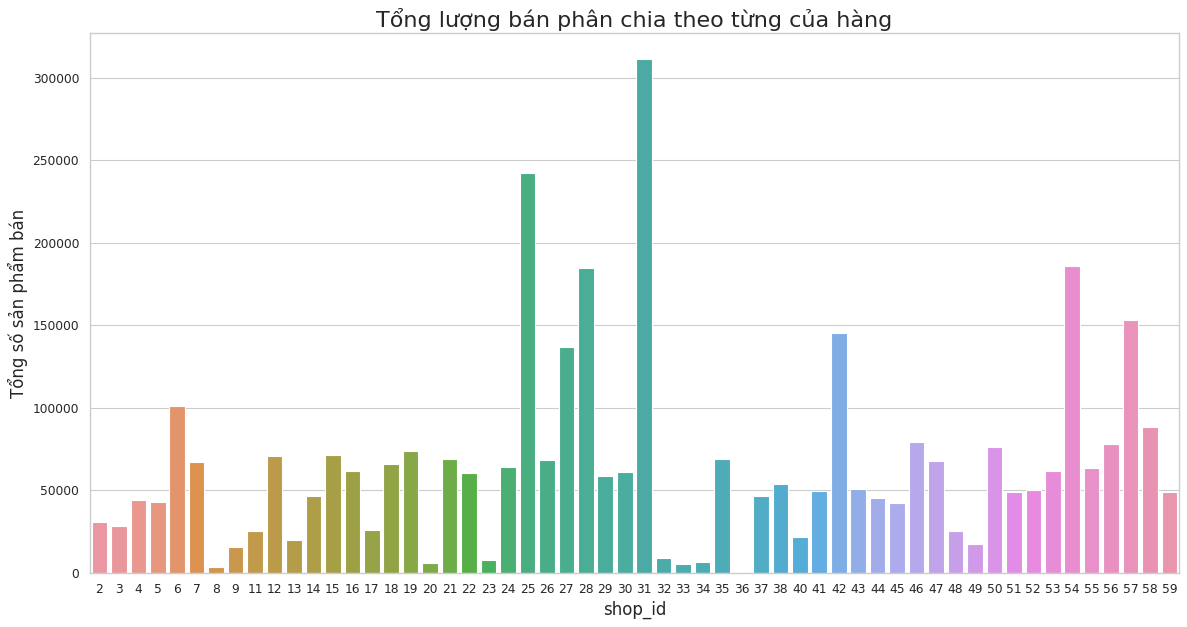

In [25]:
train_copy = sales_train.copy()
train_copy = train_copy.groupby('shop_id')['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'item_cnt_shop'})
#Create plot
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Tổng lượng bán phân chia theo từng của hàng', size=20)
ax = sns.barplot(y='item_cnt_shop', x='shop_id' , data=train_copy.sort_values(by='item_cnt_shop', ascending=False))
plt.xlabel('shop_id', size=15)
plt.ylabel('Tổng số sản phẩm bán', size=15)
plt.tight_layout()
plt.show()
del train_copy

Ta thấy `shop_id=31` có số lượng bán hàng áp đảo so với đa số các shop còn lại.

#### 4.4.2 Trung bình lượng bán của từng cửa hàng

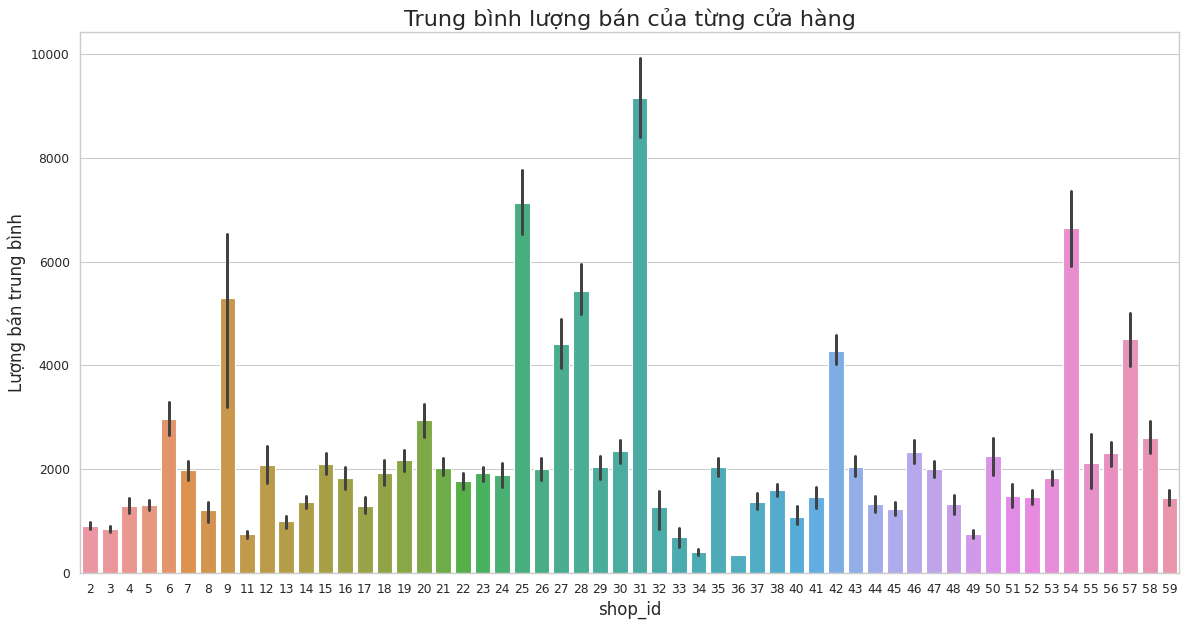

In [26]:
train_copy = sales_train.copy()
train_copy = train_copy.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'item_avg_shop'}).sort_values(by='item_avg_shop', ascending=False)
#Create plot
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Trung bình lượng bán của từng cửa hàng', size=20)
ax = sns.barplot(y='item_avg_shop', x='shop_id' , data=train_copy.sort_values(by='item_avg_shop', ascending=False))
plt.xlabel('shop_id', size=15)
plt.ylabel('Lượng bán trung bình', size=15)
plt.tight_layout()
plt.show()
del train_copy

#### 4.4.3 Tổng doanh thu của từng của hàng

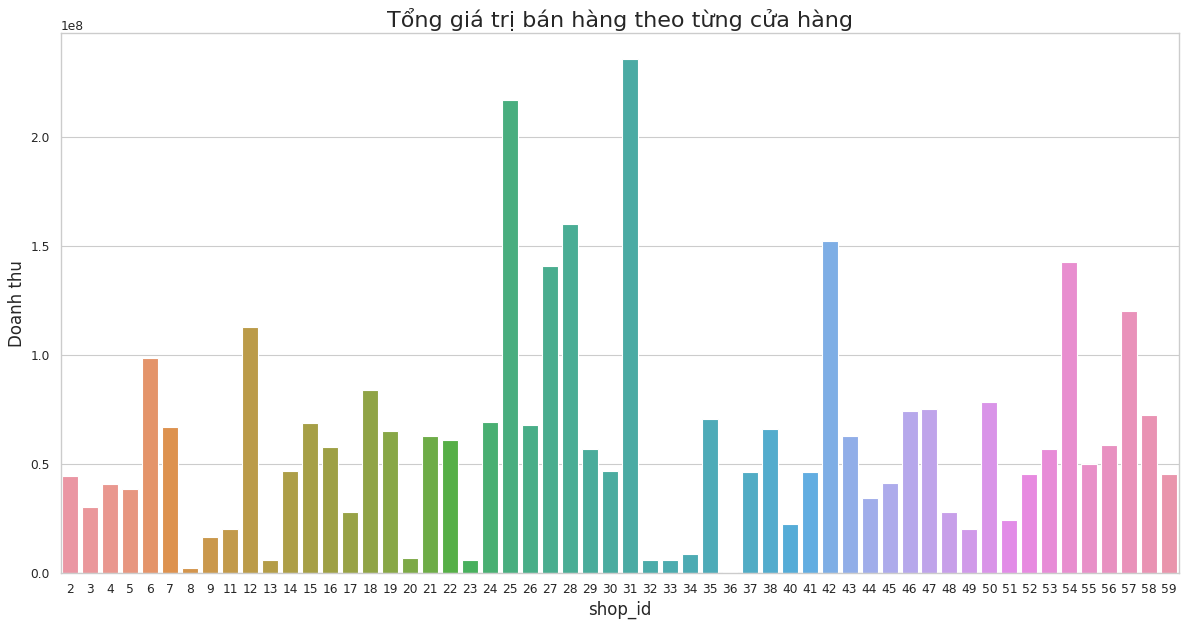

In [27]:
train_copy = sales_train.copy()
train_copy['revenue'] = train_copy['item_price'] * train_copy['item_cnt_day']
train_copy = train_copy.groupby(['shop_id']).agg({'revenue': 'sum'}).reset_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Tổng giá trị bán hàng theo từng cửa hàng', size=20)
ax = sns.barplot(x='shop_id', y='revenue', data=train_copy.sort_values(by='revenue', ascending=False))
plt.xlabel('shop_id', size=15)
plt.ylabel('Doanh thu', size=15)
plt.tight_layout()
plt.show()

del train_copy

#### 4.4.4 Top 10 sản phẩm bán chạy nhất

In [28]:
train_copy = sales_train.copy()
train_copy = pd.merge(train_copy, shops, on=['shop_id'], how='left')
train_copy = pd.merge(train_copy, items, on=['item_id'], how='left')
train_copy = pd.merge(train_copy, item_categories, on=['item_category_id'], how='left')
train_copy.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_city,shop_category,item_name,item_category_id,item_category_name,item_category_group,item_category_group_name
0,02.01.2013,0,59,22154,999.00,1.0,29,10,ЯВЛЕНИЕ 2012 (BD),37,Movies - Blu-Ray,5.0,Movies
1,03.01.2013,0,25,2552,899.00,1.0,11,12,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,6.0,Music
2,06.01.2013,0,25,2554,1709.05,1.0,11,12,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,6.0,Music


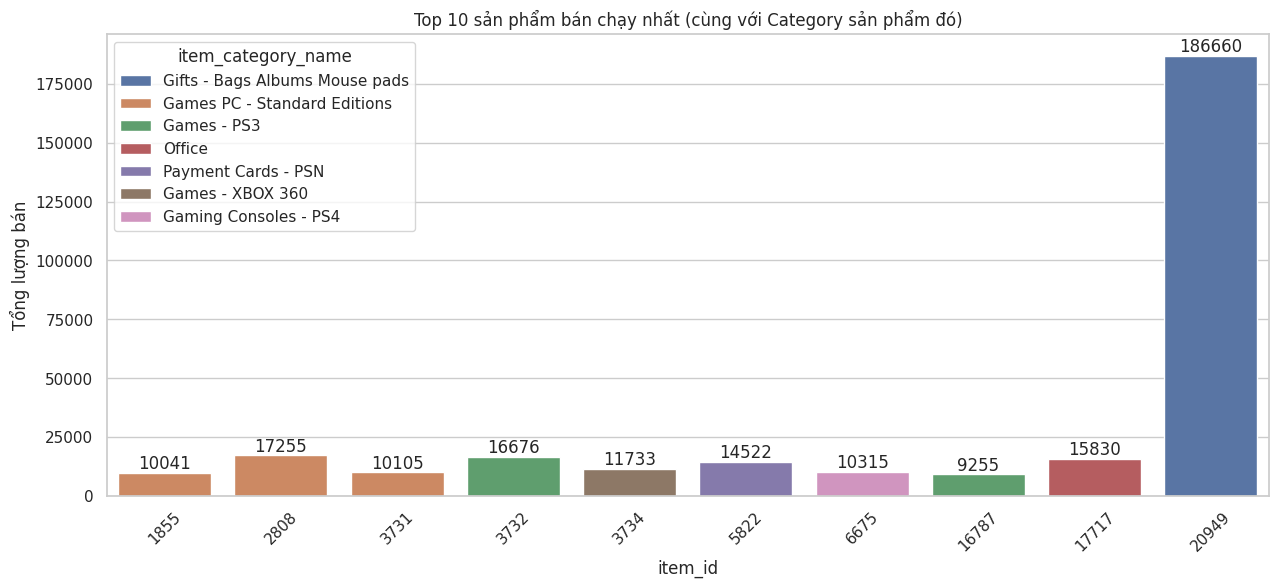

In [29]:
top_products = train_copy.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
top_products_with_category = pd.merge(top_products.reset_index(), train_copy[['item_id', 'item_category_name']], on='item_id').drop_duplicates()

#Tạo biểu đồ
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='item_id', y='item_cnt_day', hue='item_category_name', data=top_products_with_category, dodge=False)
plt.title('Top 10 sản phẩm bán chạy nhất (cùng với Category sản phẩm đó)')
plt.xlabel('item_id')
plt.ylabel('Tổng lượng bán')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.xticks(rotation=45)
plt.show()

Có thể thấy trong top 10 sản phẩm bán chạy nhất, các sản phẩm có phân loại 'Games' và 'Gaming' chiếm hầu hết các vị trí.

#### 4.4.5 Tổng lượng bán theo các nhóm phân loại sản phẩm

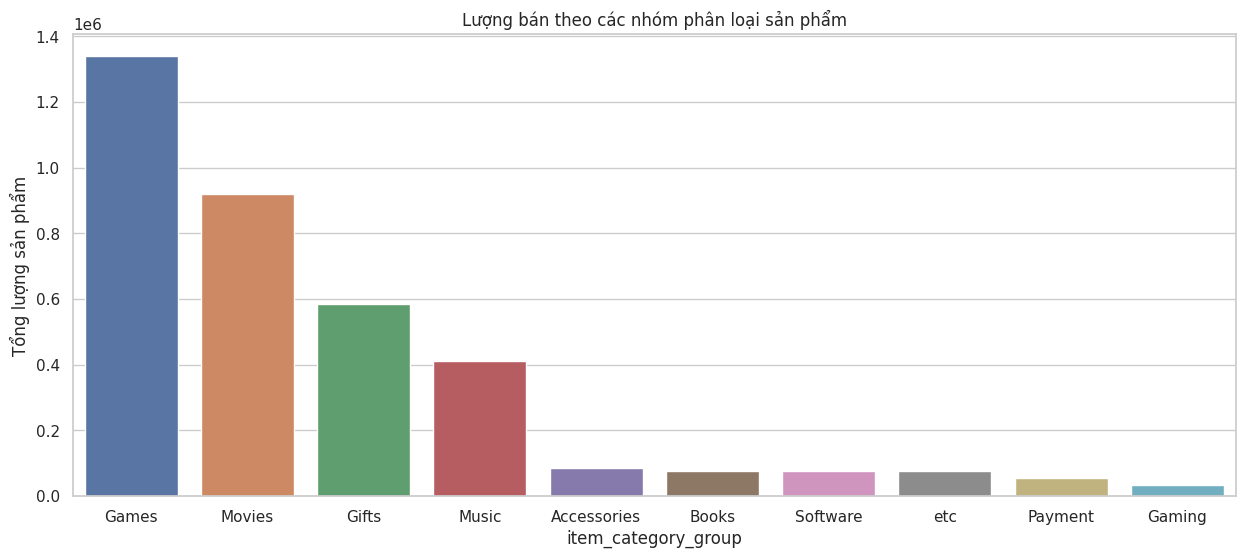

In [30]:
category_group_sales = train_copy.groupby('item_category_group_name')['item_cnt_day'].sum()
category_group_sales = category_group_sales.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=category_group_sales.index, y=category_group_sales.values, ci=None)
plt.title('Lượng bán theo các nhóm phân loại sản phẩm')
plt.xlabel('item_category_group')
plt.ylabel('Tổng lượng sản phẩm')
plt.show()
del category_group_sales

Một biểu đồ trực quan khác để thể hiện rõ hơn cho nhận xét phía trên, các sản phẩm được mua nhiều nhất thuộc về các sản phẩm liên quan đến 'Games' (bao gồm cả 'Gaming')

#### 4.4.6 Tổng lượng bán theo thành phố

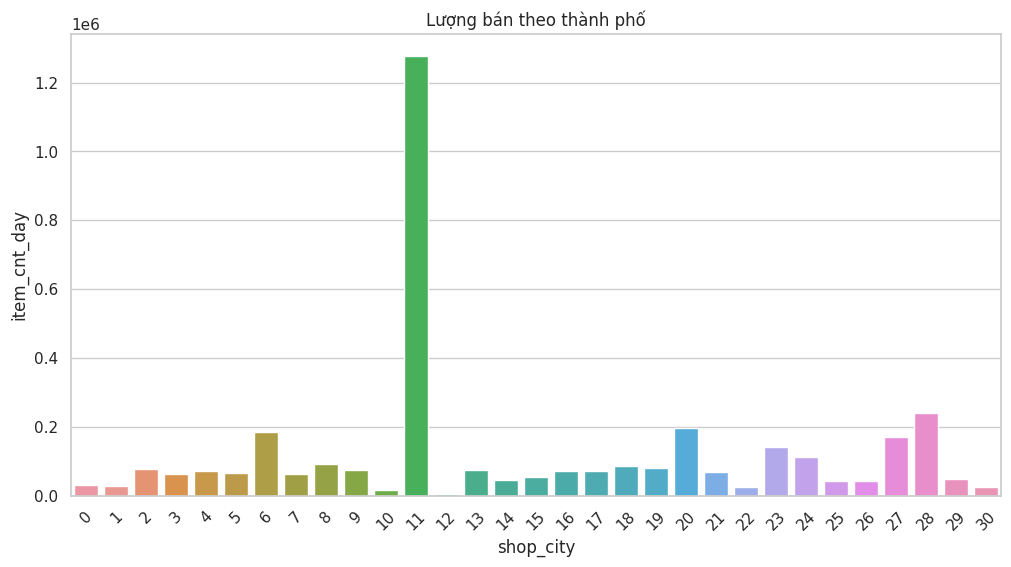

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x='shop_city', y='item_cnt_day', data=train_copy, estimator=sum, ci=None)
plt.title('Lượng bán theo thành phố')
plt.xticks(rotation=45)
plt.show()

#### 4.4.7 Tổng lượng bán theo phân loại cửa hàng

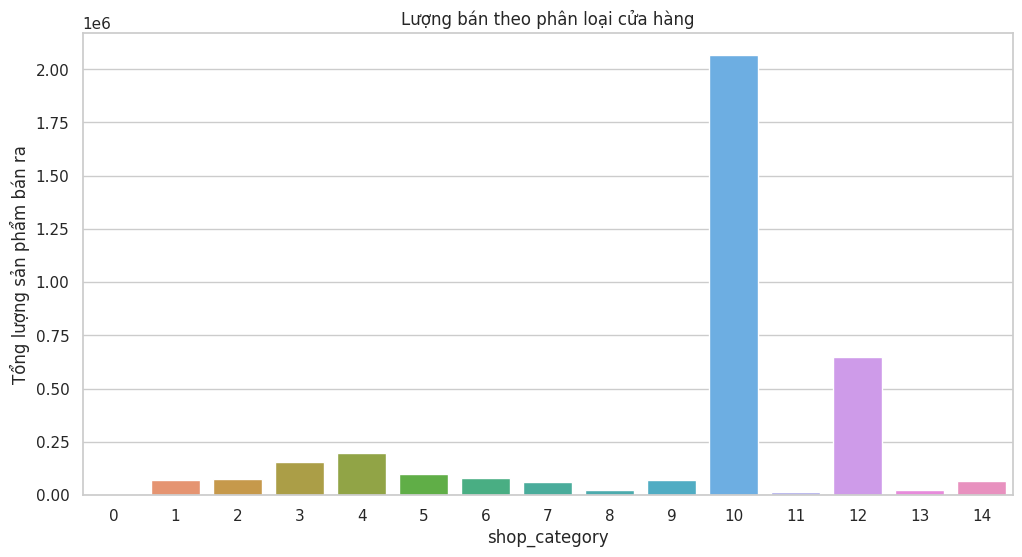

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='shop_category', y='item_cnt_day', data=train_copy, estimator=sum, errorbar=None)
plt.title('Lượng bán theo phân loại cửa hàng')
plt.xlabel('shop_category')
plt.ylabel('Tổng lượng sản phẩm bán ra')
plt.show()

In [33]:
item_categories = item_categories.drop('item_category_group_name', axis=1)
item_categories = item_categories.drop('item_category_name', axis=1)

## 5. Tạo train data

In [34]:
#định dạng thành datetime
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
#thêm feature year
sales_train['year'] = sales_train['date'].dt.year

In [35]:
train = []
# Tạo tất cả tổ hợp của date_block_num, shop_id, and item_id
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # Key features
train = pd.DataFrame(np.vstack(train), columns=idx_features)
train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10812763,33,21,7635
10812764,33,21,7638
10812765,33,21,7640
10812766,33,21,7632


In [36]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [37]:
# dọn rác
del group
gc.collect();

# II. Feature engineering

Ta gán date_block_num của tập test thành 34 và concat 2 tập test và train

In [38]:
test['date_block_num'] = 34

# Concat tập test và train
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Fill giá trị NA bằng 0
all_data = all_data.fillna(0)
all_data.head()


,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


Thêm feature độ dài tên item

In [39]:
items['item_name_length'] = items['item_name'].str.len()
items = items.drop(['item_name'], axis=1)

Thêm feature tháng đầu tiên sản phẩm được bán. Những sản phẩm chưa từng được bán thì ta gán first_sale_month=34

In [40]:
items['first_sale_month'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_month'] = items['first_sale_month'].fillna(34)
items.head()

,item_id,item_category_id,item_name_length,first_sale_month
0,0,40,41,20.0
1,1,76,68,15.0
2,2,40,45,19.0
3,3,40,47,18.0
4,4,40,43,20.0


Ta merge all_data với các tập dữ liệu đã xử lý ở trên

In [41]:
# Merge với các dữ liệu khác
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Giảm kích cỡ
all_data = downcast(all_data)
all_data.head()

72.7% compressed


,date_block_num,shop_id,item_id,item_cnt_month,item_price,shop_city,shop_category,item_category_id,item_name_length,first_sale_month,item_category_group
0,0,59,22154,1,999.0,29,10,37,17,0,5.0
1,0,59,2552,0,0.0,29,10,58,40,0,6.0
2,0,59,2554,0,0.0,29,10,58,40,0,6.0
3,0,59,2555,0,0.0,29,10,56,39,0,6.0
4,0,59,2564,0,0.0,29,10,59,50,0,6.0


In [42]:
# Dọn dữ liệu rác
del shops, items, item_categories
gc.collect();

Hàm tính số lượng sản phẩm trung bình được bán cho các groupby. Ví dụ nếu groupby shop_id thì sẽ trả về trung bình số sản phẩm từng tháng cho shop đó

In [43]:
def add_mean_features(df, mean_features, idx_features):
    # mean_features chứa những tên cột mean feature đã được tạo
    # idx_features chứa tên cột dùng để groupby
    
    # Đặt tên cột mean feature
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_item_cnt_month'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_item_cnt_month'
    
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    df = df.merge(group, on=idx_features, how='left')
    # Giảm kích cỡ df
    df = downcast(df, verbose=False)
    # Thêm tên những cột đã tạo vào mảng mean_features
    mean_features.append(feature_name)
    
    # Dọn rác
    del group
    gc.collect()
    
    return df, mean_features


In [44]:
# Mảng lưu những cột được tạo mean_features liên quan đến item_id
item_mean_features = []

# Mean feature cho ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Mean feature cho ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'shop_city'])


In [45]:
# Mảng lưu những cột được tạo mean_features liên quan đến shop_id
shop_mean_features = []

# Mean feature cho ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])


Hàm tạo lag feature

In [46]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Chỉ giữ những cột cần thiết cho việc tạo lag feature
    df_temp = df[idx_features + [lag_feature]].copy() 
    
    for i in range(1, nlags+1):
        lag_feature_name = lag_feature +'_lag' + str(i)
        df_temp.columns = idx_features + [lag_feature_name]
        df_temp['date_block_num'] += 1
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    df = downcast(df, False)
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip


In [47]:
lag_features_to_clip = []
idx_features = ['date_block_num', 'shop_id', 'item_id'] 

all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True) 


In [48]:
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price', 
                                                  nlags=3)


In [49]:
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# Bỏ feature item_mean_features 
all_data = all_data.drop(item_mean_features, axis=1)

# Tạo lag feature cho các feature trong shop_mean_features dựa trên ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# Bỏ các feature trong shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

# Bỏ những dòng có date_block_num < 3 
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)


In [50]:
# Trung bình 3 lag
all_data['item_cnt_month_lag_average'] = all_data[['item_cnt_month_lag1',
                                                  'item_cnt_month_lag2', 
                                                  'item_cnt_month_lag3']].mean(axis=1)

# Clip số lượng bán ra trong khoảng 0-20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_average']] = all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_average']].clip(0, 20)

# Feature tỉ lệ lag của doanh số tháng 1 và 2 
all_data['lag_change_ratio_1'] = all_data['item_cnt_month_lag1'] / all_data['item_cnt_month_lag2']
all_data['lag_change_ratio_1'] = all_data['lag_change_ratio_1'].replace([np.inf, -np.inf], 
                                                                        np.nan).fillna(0)

# Feature tỉ lệ lag của doanh số tháng 2 và 3 
all_data['lag_change_ratio_2'] = all_data['item_cnt_month_lag2'] / all_data['item_cnt_month_lag3']
all_data['lag_change_ratio_2'] = all_data['lag_change_ratio_2'].replace([np.inf, -np.inf], 
                                                                        np.nan).fillna(0)

# Tạo feature sản phẩm đó đã được bán bao giờ hay chưa
all_data['is_new_item'] = all_data['first_sale_month'] == all_data['date_block_num']

# Tạo feature số tháng kể từ khi sản phẩm đó lần đầu được bán
all_data['months_since_first_sale'] = all_data['date_block_num'] - all_data['first_sale_month']

# Tạo feature tháng
all_data['month'] = all_data['date_block_num'] % 12

# Bỏ một số cột không cần thiết
all_data = all_data.drop(['first_sale_month', 'item_price'], axis=1)

# Giảm kích cỡ dữ liệu
all_data = downcast(all_data, False)

# Danh sách các feature đã tạo
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9904582 entries, 1122386 to 11026967
Data columns (total 30 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   date_block_num                                     int8   
 1   shop_id                                            int8   
 2   item_id                                            int16  
 3   item_cnt_month                                     int8   
 4   shop_city                                          int8   
 5   shop_category                                      int8   
 6   item_category_id                                   int8   
 7   item_name_length                                   int16  
 8   item_category_group                                float32
 9   item_cnt_month_lag1                                int8   
 10  item_cnt_month_lag2                                int8   
 11  item_cnt_month_lag3                        

# III. Mô hình
## 1. Chuẩn bị train, test, validation

In [51]:
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)

X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)

X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']

y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

del all_data
gc.collect();


## 2. Huấn luyện mô hình

In [52]:
params = {
           'metric': 'rmse', 
           'num_leaves': 255,
           'learning_rate': 0.005,
           'feature_fraction': 0.75,
           'bagging_fraction': 0.75,
           'bagging_freq': 5,
           'force_col_wise': True,
           'random_state': 10,
           'early_stopping_rounds' : 150,
           'verbose' : 100
}

cat_features = ['shop_id', 'shop_city', 'item_category_id', 'item_category_group', 'month']

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.837673
[LightGBM] [Info] Total Bins 3953
[LightGBM] [Info] Number of data points in the train set: 9452298, number of used features: 29
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 0.297707
[LightGBM] [Debug] Re-bagging, using 7090220 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 19
Training until validation scores don't improve for 150 rounds
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 16
[LightGBM] [Debug] Re-bagging, using 7089074 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 255 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves =

In [53]:
submission = X_test.copy()
preds = lgb_model.predict(X_test).clip(0, 20)
submission['item_cnt_month'] = preds

In [54]:
submission_final = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": submission['item_cnt_month']
})
submission_final

,ID,item_cnt_month
10812768,0,0.382955
10812769,1,0.390418
10812770,2,0.817821
10812771,3,0.393793
10812772,4,1.393330
...,...,...
11026963,214195,0.089364
11026964,214196,0.021979
11026965,214197,0.045525
11026966,214198,0.019076


In [55]:
submission_final.to_csv("submissio123n.csv", index=False)